# Figure B: Cross section

In [50]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib
from matplotlib.colors import ListedColormap
import xarray as xr 

#plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings("ignore")

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Get libraries for precise axis control
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec

In [51]:
def compute_air_density(temperature, pressure):
    R_d = 287.05  # J/(kg·K), specific gas constant for dry air
    air_density = pressure / (R_d * temperature)
    return air_density

In [52]:
def assign_h_as_coors(data, h):
    data = data.assign_coords(height=h)
    return data

## Prepare Data

In [53]:
frp =  xr.open_mfdataset("/work/bb1174/user/jason/hamlite/icon_input/data_any_2019/frp/frp_any_2019.nc", engine = 'netcdf4').isel(time = 30)

In [171]:
data_path = "/work/bb1262/b381531/frp_experiments/lam_aus_2019/run_20191230T000000-20191230T235955/"
ca = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z_regrid.nc", engine = 'netcdf4').num_qca
dust = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z_regrid.nc", engine = 'netcdf4').num_qdu
h = xr.open_mfdataset("/work/bb1262/b381531/frp_experiments/lam_aus_2019/run_20191226T000000-20191226T235955/lam_aus_2019_atm_vgrid_ml.nc", engine = 'netcdf4').zg.mean("ncells")/1000

h = h.rename({"height_2": "height"})

In [172]:
# Get height of Troposphere
tropoheight = xr.open_mfdataset(data_path + "*std*Z.nc", engine = 'netcdf4').ptp.mean(("ncells", "time"))
p = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z.nc", engine = 'netcdf4').pfull.mean(("ncells", "time"))

closest_index = np.abs(p - tropoheight).argmin().values.item()
tropoheight = h[closest_index].values

In [173]:
ca = ca.assign_coords(height=h)
dust = dust.assign_coords(height=h)

In [174]:
lon = dust.lon
lat = dust.lat

## Plot Crosssection

In [175]:
# Get the colormaps right
nlevel = 50

base_cmap = plt.cm.get_cmap("gist_heat_r", nlevel)  
colors = base_cmap(np.linspace(0, 1, nlevel))
colors[0] = [1, 1, 1, 0]
custom_cmap_du = ListedColormap(colors)

base_cmap = plt.cm.get_cmap("Greys", nlevel)  
colors = base_cmap(np.linspace(0, 1, nlevel))
colors[0] = [1, 1, 1, 0]
colors[1] = [1, 1, 1, 0.25]
colors[2] = [1, 1, 1, 0.75]
custom_cmap_ca = ListedColormap(colors)

In [218]:
# Some Settings for the crosssection - plot
time = 0 

maxval_ca = 5
maxval_du = 5
levs_ca = np.arange(0, maxval_ca, maxval_ca / nlevel)
levs_du = np.arange(0, maxval_du, maxval_du / nlevel)

center_lat = -36.5 #Adjust the center latitude
dlat = 2  #Adjust the space around the center latitude where the data should be averaged in 

## Transect in a latitude band
dust_sec = dust.isel(time = time).sel(lat = slice(center_lat - dlat, center_lat + dlat)).mean("lat")*1e-6
ca_sec = ca.isel(time = time).sel(lat = slice(center_lat - dlat, center_lat + dlat)).mean("lat")*1e-9

# Alternative: Transect in a single latitude line
#dust_sec = dust.isel(time = time).sel(lat = center_lat, method = "nearest")*1e-7
#ca_sec = ca.isel(time = time).sel(lat = center_lat, method = "nearest")*1e-9


In [219]:
# Some Settings for the domain - mean - plot
dust_scaling_factor = 1e-5
ca_scaling_factor = 1e-8
dust_mean = dust.isel(time = time).mean(("lat", "lon"))*dust_scaling_factor
ca_mean = ca.isel(time = time).mean(("lat", "lon"))* ca_scaling_factor

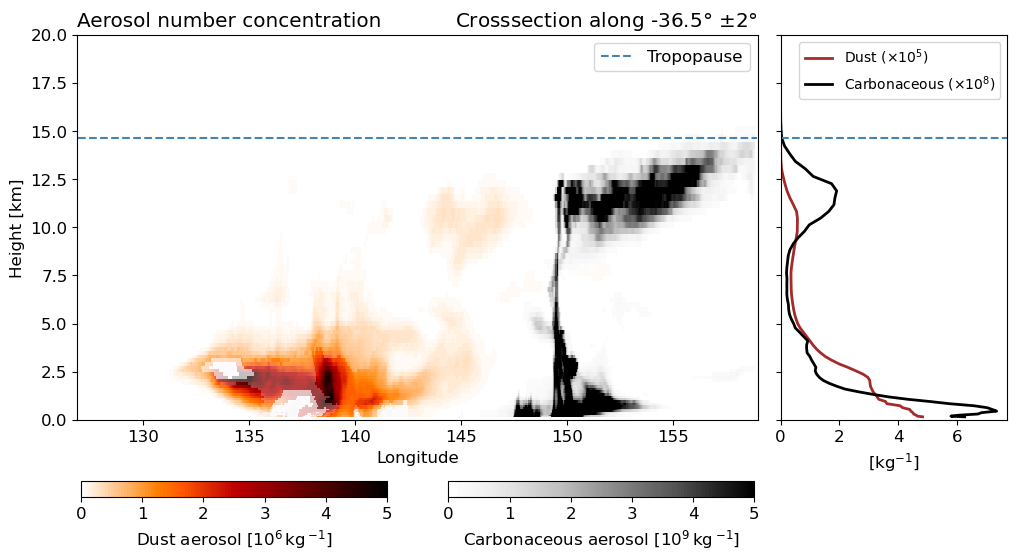

In [221]:
# Set up main figure with custom width ratios: 3 for main plot, 1 for profile
fig = plt.figure(figsize=(12, 5))  # Slightly wider to accommodate profile
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)

# Main cross-section plot
ax = fig.add_subplot(gs[0])

# Plot with fixed levels
c1 = ax.pcolormesh(lon, h, dust_sec, cmap=custom_cmap_du, vmin=0, vmax=maxval_du)
c2 = ax.pcolormesh(lon, h, ca_sec, cmap=custom_cmap_ca, vmin=0, vmax=maxval_ca)

# Plot with free levels
#c1 = ax.pcolormesh(lon, h, dust_sec, cmap=custom_cmap_du)
#c2 = ax.pcolormesh(lon, h, ca_sec, cmap=custom_cmap_ca)

# Tropopause line
ax.hlines(y=tropoheight, xmin=np.min(lon), xmax=np.max(lon), label="Tropopause", colors="steelblue", linestyle="--")
ax.legend()

# Axis formatting
ax.set_ylim(0, 20)
ax.set_xlabel("Longitude")
ax.set_ylabel("Height [km]")
ax.set_title("Aerosol number concentration", loc="left")
ax.set_title(f"Crosssection along {center_lat}° $\pm${dlat}°", loc="right")

# Horizontal colorbars below the main plot
cbar_ax1 = inset_axes(ax, width="45%", height="4%", loc='lower center',
                      bbox_to_anchor=(-0.27, -0.2, 1, 1), bbox_transform=ax.transAxes, borderpad=0)

cbar_ax2 = inset_axes(ax, width="45%", height="4%", loc='lower center',
                      bbox_to_anchor=(0.27, -0.2, 1, 1), bbox_transform=ax.transAxes, borderpad=0)

cb1 = fig.colorbar(c1, cax=cbar_ax1, orientation='horizontal')
cb1.set_label("Dust aerosol [10$^{6}\,$kg$\,^{{-1}}$]")

cb2 = fig.colorbar(c2, cax=cbar_ax2, orientation='horizontal')
cb2.set_label("Carbonaceous aerosol [10$^{9}\,$kg$\,^{{-1}}$]")

# Profile plot on the right
ax_profile = fig.add_subplot(gs[1], sharey=ax)
ax_profile.plot(dust_mean, h, label=r"Dust ($\times 10^{{5}}$)", color="brown", linewidth = 2)
ax_profile.plot(ca_mean, h, label=r"Carbonaceous (${\times} 10^{{8}}$)", color="black",  linewidth = 2)
ax_profile.set_xlabel(f"[kg$^{{-1}}$]")
ax_profile.legend(loc = "upper right", fontsize = 10)
ax_profile.set_xlim(left=0)  
ax_profile.tick_params(labelleft=False)  # Hide y-axis labels (shared)
ax_profile.axhline(y=tropoheight, color="steelblue", linestyle="--", label="Tropopause")

plt.tight_layout()
plt.show()
